# Linear Regression  
In this notebook I iterated over building a model and functions multiple times. While it is not the final version I decided to go with and the notebook has not been cleaned I felt it was useful to still include work done. People learn by doing and here the doing is. 

In [1]:
 #library imports 
import pandas as pd  
import pandasql
import numpy as np  

from statsmodels.formula.api import ols 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import statsmodels.api as sm
import scipy.stats as stats 
from sklearn.model_selection import train_test_split  

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from itertools import combinations

import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns  

import warnings
warnings.filterwarnings('ignore') 

## Data Initialization and Visualization

In [2]:
%store -r df
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
#copy working df to a df called: lr_df
lr_df = df.copy() 
lr_df = lr_df.drop(['date', 'id'], axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017DF279AD00>,
      dtype=object)

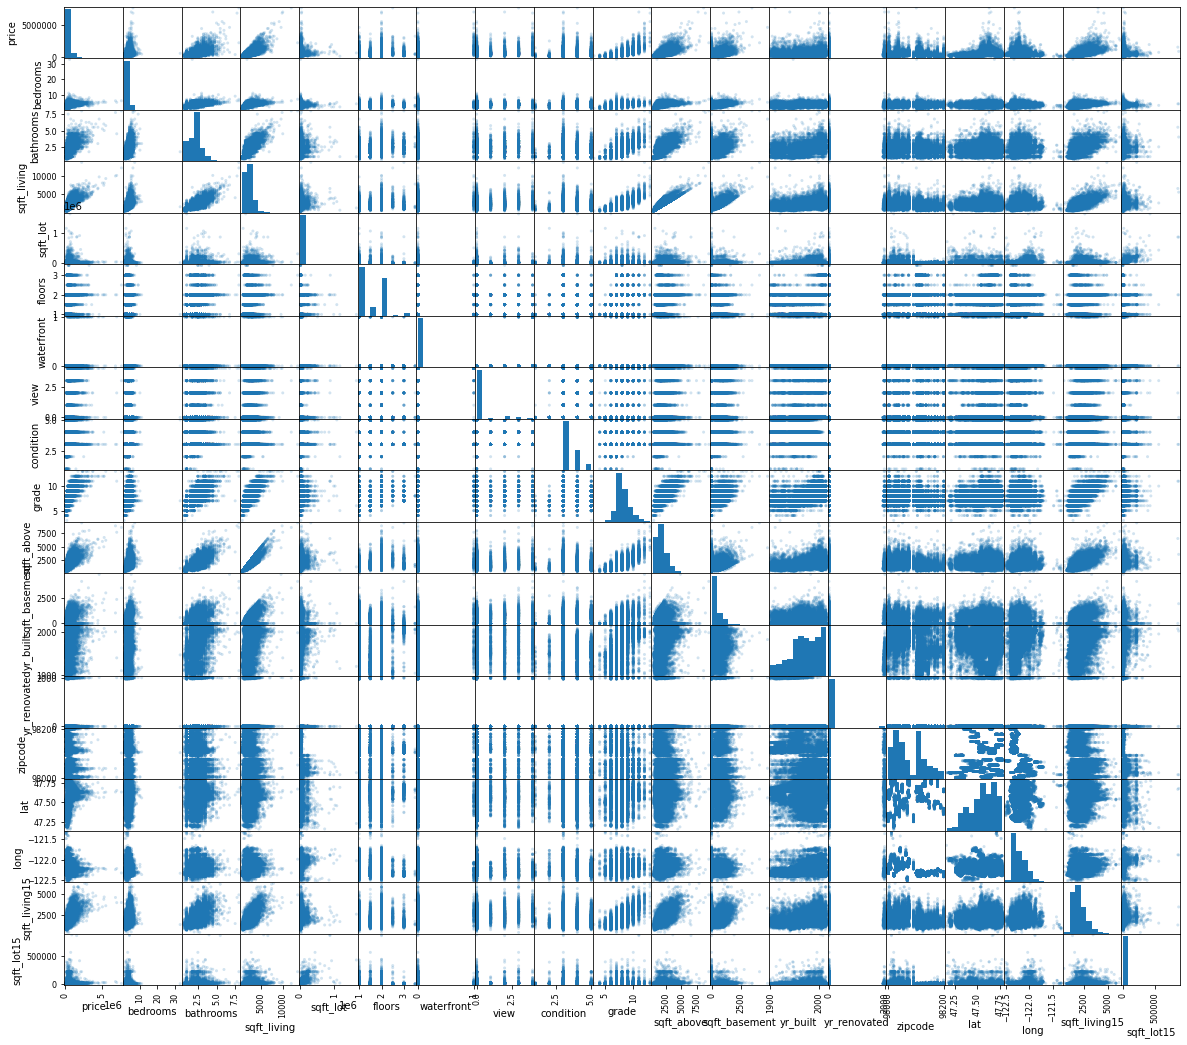

In [4]:
#data distribution visualization  
pd.plotting.scatter_matrix(lr_df, alpha=0.2, figsize=(20,18))

## Functions

In [38]:
def build_sm_ols(df, features_to_use, target, add_constant=False, show_summary=True):
    X = df[features_to_use]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X).fit()
    if show_summary:
        print(ols.summary())
    return ols

# assumptions of ols
# residuals are normally distributed
def check_residuals_normal(ols):
    residuals = ols.resid
    t, p = stats.shapiro(residuals)
    if p <= 0.05:
        return False
    return True


# residuals are homoskedasticitous
def check_residuals_homoskedasticity(ols):
    import statsmodels.stats.api as sms
    resid = ols.resid
    exog = ols.model.exog
    lg, p, f, fp = sms.het_breuschpagan(resid=resid, exog_het=exog)
    if p >= 0.05:
        return True
    return False




def check_vif(df, features_to_use, target_feature):
    ols = build_sm_ols(df=df, features_to_use=features_to_use, target=target_feature, show_summary=False)
    r2 = ols.rsquared
    return 1 / (1 - r2)
    
    
    
# no multicollinearity in our feature space
def check_vif_feature_space(df, features_to_use, vif_threshold=3.0):
    all_good_vif = True
    for feature in features_to_use:
        target_feature = feature
        _features_to_use = [f for f in features_to_use if f!=target_feature]
        vif = check_vif(df=df, features_to_use=_features_to_use, target_feature=target_feature)
        if vif >= vif_threshold:
            print(f"{target_feature} surpassed threshold with vif={vif}")
            all_good_vif = False
    return all_good_vif
        
        


def check_model(df, 
                features_to_use, 
                target_col, 
                add_constant=False, 
                show_summary=False, 
                vif_threshold=3.0):
    has_multicollinearity = check_vif_feature_space(df=df, 
                                                    features_to_use=features_to_use, 
                                                    vif_threshold=vif_threshold)
    if not has_multicollinearity:
        print("Model contains multicollinear features")
    
    # build model 
    ols = build_sm_ols(df=df, features_to_use=features_to_use, 
                       target=target_col, add_constant=add_constant, 
                       show_summary=show_summary)
    
    # check residuals
    resids_are_norm = check_residuals_normal(ols)
    resids_are_homo = check_residuals_homoskedasticity(ols)
    
    if not resids_are_norm or not resids_are_homo:
        print("Residuals failed test/tests")
    return ols

In [5]:
def correlation_check(x_cols, df, outcome='price'):  
    """outcome= taget column name
        x_cols - independent variables 
        df = working dataframe 
        
        Returns:
        correlation 
        heatmap 
        """
    #correlation check
    feats = x_cols 
    corr = df[feats].corr()  
    
    #heatmap 
    sns.heatmap(corr, center=0, annot=True)   
     
    print("Correlation:", corr)

In [6]:
def linear_regression(x_cols, df, outcome='price'):  
    """outcome= taget column name
        x_cols - independent variables 
        df = working dataframe 
        
        returns 
        baseline R2 
        OLS Model Summary 
        VIF scores 
        QQPlot 
        Pvalues Table"""

    #baseline model 
    y = df[['price']]
    X = df.drop(['price'], axis=1) 

    regression = LinearRegression()
    crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1) 
    
    baseline= np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
    baseline 
    
    #fit model 
    predictors = '+'.join(x_cols) 
    formula = outcome + "~" + predictors
    model = ols(formula=formula, data=df).fit()
    model.summary() 
    
    #vif scores
    X = df[x_cols] 
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]  
    
    #normality check
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)  
    
    #pvalues
    summary = model.summary()
    p_table = summary.tables[1]
    p_table = pd.DataFrame(p_table.data)
    p_table.columns = p_table.iloc[0]
    p_table = p_table.drop(0)
    p_table = p_table.set_index(p_table.columns[0])
    p_table['P>|t|'] = p_table['P>|t|'].astype(float)
    x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
    x_cols.remove('Intercept')
    
    print("Baseline:", baseline)  
    print(model.summary()) 
    print("\n")
    print("Vif Scores:", list(zip(x_cols, vif)))   
    print("\n")
    print(len(p_table), len(x_cols))
    print(x_cols[:5])
    print(p_table.head())

In [7]:
def calc_slope(xs, ys):

    m = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys)) /
         ((np.mean(xs)**2) - np.mean(xs*xs)))
    
    return m

## Create Test and Trial Data  
Sepearte the data so that we can train and test on different values.

In [8]:
#train & test groups
train, test = train_test_split(lr_df) 
print("Train:", len(train), "Test:", len(test))

Train: 16197 Test: 5400


In [9]:
train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
10717,425000.0,4,1.00,1800,12485,1.0,0.0,0.0,5,7,950,850.0,1955,0.0,98006,47.5729,-122.147,1290,9840
15256,457000.0,2,1.75,2060,7192,1.0,0.0,0.0,3,7,1420,640.0,1940,0.0,98125,47.7038,-122.317,1860,7140
7687,299900.0,3,1.75,1470,27000,1.0,0.0,0.0,3,7,1470,0.0,1958,0.0,98198,47.3943,-122.311,2230,14186
15258,237000.0,3,2.00,1210,6634,1.0,0.0,0.0,4,7,1210,0.0,1985,0.0,98031,47.4097,-122.193,1560,7200
324,232000.0,2,1.00,1240,12092,1.0,0.0,0.0,3,6,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460


## Trial 1 
This trial is done with the full data set, unmanipulated 

In [10]:
#define the problem 
outcome = 'price'
t1 = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

Baseline: 0.6971033799571931
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     2173.
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:37:29   Log-Likelihood:            -2.2109e+05
No. Observations:               16197   AIC:                         4.422e+05
Df Residuals:                   16179   BIC:                         4.424e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.

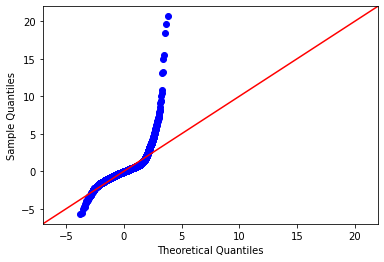

In [11]:
linear_regression(x_cols=t1, df=train, outcome='price')

Correlation:                bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
bedrooms       1.000000   0.472154     0.539998  0.034967  0.179058   
bathrooms      0.472154   1.000000     0.770101  0.086805  0.512749   
sqft_living    0.539998   0.770101     1.000000  0.149958  0.368050   
sqft_lot       0.034967   0.086805     0.149958  1.000000 -0.017216   
floors         0.179058   0.512749     0.368050 -0.017216  1.000000   
waterfront    -0.001796   0.073678     0.100209  0.014070  0.030044   
view           0.068588   0.199797     0.279639  0.091335  0.043491   
condition      0.031075  -0.134747    -0.071724 -0.003529 -0.259349   
grade          0.335260   0.684288     0.771385  0.098897  0.465533   
sqft_above     0.445571   0.698067     0.882410  0.160183  0.521175   
sqft_basement  0.276826   0.276991     0.406763  0.008415 -0.225875   
yr_built       0.136021   0.506289     0.330190  0.034811  0.473822   
yr_renovated   0.016414   0.059479     0.062796  0.003838  0.020

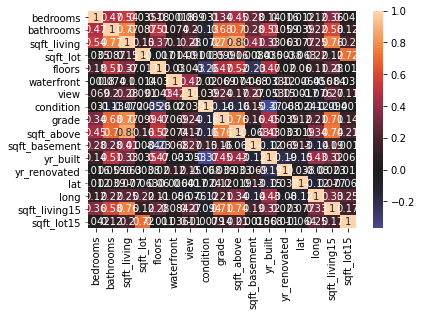

In [13]:
#correlation test 
correlation_check(x_cols=t1, df=test, outcome='price')

The rsquared value for this trial (0.692) is relatively low and the qq plot shows there is a large tail my refining will be to drop outlying data from the train data.

## Trail 2 
Remove outlying data greater than 3 STD from the mean

In [14]:
#define the problem 
outcome = 'price'
t2 = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

In [15]:
#look at z scores (relationship to the std & mean) 
z = np.abs(stats.zscore(train)) 
threshold = 3 #3 std away from them mean
print(np.where(z > 3))

(array([    4,     5,     5, ..., 16183, 16186, 16186], dtype=int64), array([13,  4, 18, ..., 13,  4, 16], dtype=int64))


In [16]:
#drop anything outside 3 std and set it to a new dataframe named "df_1"
train = train[(z<3).all(axis=1)]
train.head() 

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
10717,425000.0,4,1.00,1800,12485,1.0,0.0,0.0,5,7,950,850.0,1955,0.0,98006,47.5729,-122.147,1290,9840
15256,457000.0,2,1.75,2060,7192,1.0,0.0,0.0,3,7,1420,640.0,1940,0.0,98125,47.7038,-122.317,1860,7140
7687,299900.0,3,1.75,1470,27000,1.0,0.0,0.0,3,7,1470,0.0,1958,0.0,98198,47.3943,-122.311,2230,14186
15258,237000.0,3,2.00,1210,6634,1.0,0.0,0.0,4,7,1210,0.0,1985,0.0,98031,47.4097,-122.193,1560,7200
13289,265000.0,3,2.25,1840,6750,1.0,0.0,0.0,4,7,1270,570.0,1980,0.0,98031,47.4075,-122.172,1750,7004


Baseline: 0.6752766475392263
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     1934.
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:40:59   Log-Likelihood:            -1.8717e+05
No. Observations:               14151   AIC:                         3.744e+05
Df Residuals:                   14135   BIC:                         3.745e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.

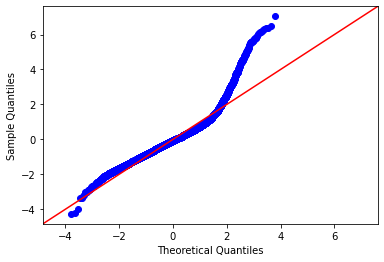

In [17]:
linear_regression(x_cols=t2, df=train, outcome='price')

Removing the outliers dropped the rsquared value (0.675) but created a less exagerated tail on the qqplot. My next refinment will be to drop any columns whose PValue is > 0.05. 

## Trial 3 
Removing "sqft_lot" & "sqft_basement" do to higher than 0.05 pvalues

In [18]:
#redefine the problem 
outcome = 'price'
t3 = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

Baseline: 0.6752766475392263
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     2231.
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:41:09   Log-Likelihood:            -1.8717e+05
No. Observations:               14151   AIC:                         3.744e+05
Df Residuals:                   14137   BIC:                         3.745e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.

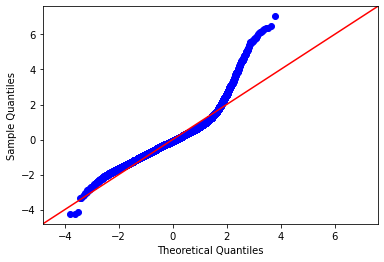

In [19]:
linear_regression(x_cols=t3, df=train, outcome='price')

Removing the columns did not have an affect on the rsquared score of the model. The next piece of model refinement will be to remove vif scores greater than 100.

## Trial 4 
Remove 'yr_built', 'lat', 'long', 'grade'

In [20]:
#redefine the problem 
outcome = 'price'
t4 = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'condition',
          'sqft_above', 'yr_renovated', 'sqft_living15', 'sqft_lot15']

Baseline: 0.6752766475392263
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     1250.
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:41:13   Log-Likelihood:            -1.9092e+05
No. Observations:               14151   AIC:                         3.819e+05
Df Residuals:                   14141   BIC:                         3.819e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.

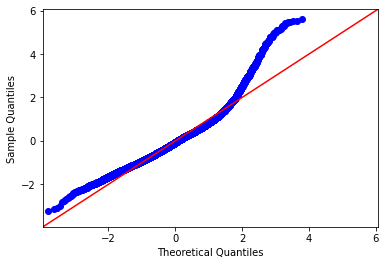

In [21]:
linear_regression(x_cols=t4, df=train, outcome='price')

Correlation:                bedrooms  bathrooms  sqft_living    floors  waterfront  \
bedrooms       1.000000   0.488627     0.607338  0.155664         NaN   
bathrooms      0.488627   1.000000     0.709252  0.515287         NaN   
sqft_living    0.607338   0.709252     1.000000  0.352987         NaN   
floors         0.155664   0.515287     0.352987  1.000000         NaN   
waterfront          NaN        NaN          NaN       NaN         NaN   
view           0.038666   0.069956     0.127576 -0.018432         NaN   
condition      0.027839  -0.141364    -0.067151 -0.287652         NaN   
sqft_above     0.481188   0.628963     0.853387  0.540196         NaN   
yr_renovated        NaN        NaN          NaN       NaN         NaN   
sqft_living15  0.404785   0.535042     0.747708  0.279036         NaN   
sqft_lot15     0.113182   0.059366     0.226791 -0.102300         NaN   

                   view  condition  sqft_above  yr_renovated  sqft_living15  \
bedrooms       0.038666   0.027

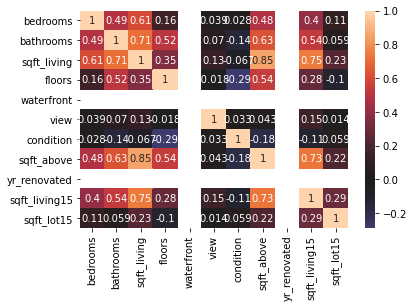

In [22]:
correlation_check(x_cols=t4, df=train, outcome='price')

Removing these columns had a detrimental affect on my rsquared score (dropping it to 0.448) the warnings indicate that there might be strong collinearity. Preforming a colleniarity check shows that sqft_living & sqft_above have a 0.86 correlation and sqft_living & sqft_living15 have a 0.75 correlation so I will remove those two from the next trial

## Trial 5
Remove sqft_living15 & sqft_above 

In [23]:
#redefine the problem 
outcome = 'price'
t5 = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'condition', 'yr_renovated', 'sqft_lot15']

Baseline: 0.6752766475392263
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     1485.
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:41:32   Log-Likelihood:            -1.9116e+05
No. Observations:               14151   AIC:                         3.823e+05
Df Residuals:                   14143   BIC:                         3.824e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -3.219

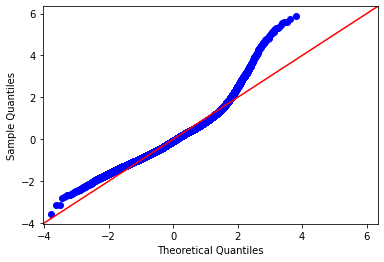

In [24]:
linear_regression(x_cols=t5, df=train, outcome='price')

Correlation:               bedrooms  bathrooms  sqft_living    floors  waterfront  \
bedrooms      1.000000   0.488627     0.607338  0.155664         NaN   
bathrooms     0.488627   1.000000     0.709252  0.515287         NaN   
sqft_living   0.607338   0.709252     1.000000  0.352987         NaN   
floors        0.155664   0.515287     0.352987  1.000000         NaN   
waterfront         NaN        NaN          NaN       NaN         NaN   
view          0.038666   0.069956     0.127576 -0.018432         NaN   
condition     0.027839  -0.141364    -0.067151 -0.287652         NaN   
yr_renovated       NaN        NaN          NaN       NaN         NaN   
sqft_lot15    0.113182   0.059366     0.226791 -0.102300         NaN   

                  view  condition  yr_renovated  sqft_lot15  
bedrooms      0.038666   0.027839           NaN    0.113182  
bathrooms     0.069956  -0.141364           NaN    0.059366  
sqft_living   0.127576  -0.067151           NaN    0.226791  
floors       -0.01

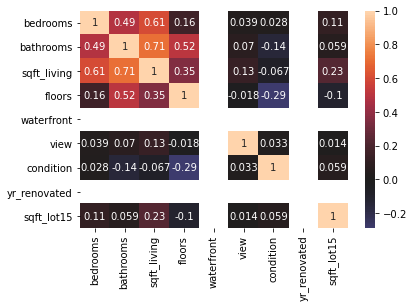

In [25]:
correlation_check(x_cols=t5, df=train, outcome='price')

This adjustment worsened the rsquared score. Looking at a correlation heatmap it looks like there is still strong correlation between bedrooms & sqft_living and bathrooms & sqft_living. I am going to remove sqft living from the next trial. 

# Trial 6 
Remove sqft_living

In [26]:
#redefine the problem 
outcome = 'price'
t6 = ['bedrooms', 'bathrooms', 'floors', 'condition', 'yr_renovated', 'sqft_lot15']

Baseline: 0.6752766475392263
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     835.7
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:41:48   Log-Likelihood:            -1.9323e+05
No. Observations:               14151   AIC:                         3.865e+05
Df Residuals:                   14145   BIC:                         3.865e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.108

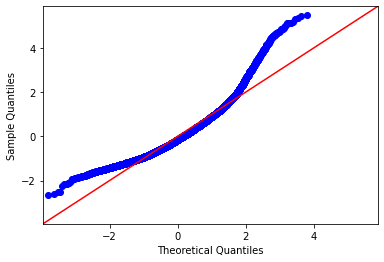

In [27]:
linear_regression(x_cols=t6, df=train, outcome='price')

Ultimately this is not producing good results and my rquared score is dropping. I am going to try a new approach to selecting features in a new notebook "Linear Regression Trails 2"

In [39]:
ols = check_model(df=train, features_to_use=t6, 
                     target_col='price', show_summary=True)

bedrooms surpassed threshold with vif=19.794376710383062
bathrooms surpassed threshold with vif=17.59889472143511
floors surpassed threshold with vif=10.412746299914433
condition surpassed threshold with vif=11.746547139615664
Model contains multicollinear features
                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.852
Model:                            OLS   Adj. R-squared (uncentered):              0.852
Method:                 Least Squares   F-statistic:                          1.631e+04
Date:                Wed, 07 Oct 2020   Prob (F-statistic):                        0.00
Time:                        11:17:24   Log-Likelihood:                     -1.9327e+05
No. Observations:               14151   AIC:                                  3.865e+05
Df Residuals:                   14146   BIC:                                  3.866e+05
Df Model:                     